In [2]:
#pip install torchvision

Note: you may need to restart the kernel to use updated packages.


In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

In [22]:
# import ssl
# import urllib.request

# # Disable SSL certificate verification
# ssl._create_default_https_context = ssl._create_unverified_context

# # Now you can run your code to download the CIFAR-10 dataset
# try:
#     trainset = datasets.CIFAR10('data', train=True, download=True, transform=transform)
#     testset = datasets.CIFAR10('data', train=False, download=True, transform=transform)
# except urllib.error.URLError as e:
#     print(f"URLError: {e}")



NameError: name 'transform' is not defined

In [23]:
# Load CIFAR-10 dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
trainset = datasets.CIFAR10('data', train=True, download=True, transform=transform)
testset = datasets.CIFAR10('data', train=False, download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [24]:
# Filter out airplane and automobile images
trainset = [(img, label) for img, label in trainset if label in [0, 1]] # airplane = 0, automobile=1 
testset = [(img, label) for img, label in testset if label in [0, 1]]

In [25]:
# Define Speaker and Listener models
class Speaker(nn.Module):
    def __init__(self):
        super(Speaker, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(3072, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 5),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = x.view(-1, 3072)
        x = self.encoder(x)
        return x
    
class Listener(nn.Module):
    def __init__(self):
        super(Listener, self).__init__()
        self.decoder = nn.Sequential(
            nn.Linear(5, 128),
            nn.ReLU(),
            nn.Linear(128, 2),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        x = self.decoder(x)
        return x

In [26]:
# Define training function
def train(speaker, listener, optimizer_speaker, optimizer_listener, criterion, trainloader):
    speaker.train()
    listener.train()
    running_loss = 0.0
    for i, (images, labels) in enumerate(trainloader):
        optimizer_speaker.zero_grad()
        optimizer_listener.zero_grad()
        messages = speaker(images)
        outputs = listener(messages)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer_speaker.step()
        optimizer_listener.step()
        running_loss += loss.item()
    return running_loss / len(trainloader)

In [27]:
# Define testing function
def test(speaker, listener, criterion, testloader):
    speaker.eval()
    listener.eval()
    test_loss = 0.0
    correct = 0
    with torch.no_grad():
        for images, labels in testloader:
            messages = speaker(images)
            outputs = listener(messages)
            test_loss += criterion(outputs, labels).item()
            predicted = outputs.argmax(dim=1)
            correct += (predicted == labels).sum().item()

    test_loss /= len(testloader)
    accuracy = correct / len(testloader.dataset)
    return test_loss, accuracy

In [28]:
# Define parameters
lr = 0.001
batch_size = 64
num_epochs = 5

In [29]:
# Create data loaders
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

In [30]:
# Initialize models and optimizers
speaker = Speaker()
listener = Listener()
criterion = nn.CrossEntropyLoss()
optimizer_speaker = optim.Adam(speaker.parameters(), lr=lr)
optimizer_listener = optim.Adam(listener.parameters(), lr=lr)

In [31]:
# Train models
for epoch in range(num_epochs):
    train_loss = train(speaker, listener, optimizer_speaker, optimizer_listener, criterion, trainloader)
    test_loss, accuracy = test(speaker, listener, criterion, testloader)
    print(f"Epoch {epoch+1}: Train Loss={train_loss:.4f}, Test Loss={test_loss:.4f}, Accuracy={accuracy:.4f}")

Epoch 1: Train Loss=0.5394, Test Loss=0.5050, Accuracy=0.7965
Epoch 2: Train Loss=0.4814, Test Loss=0.4687, Accuracy=0.8460
Epoch 3: Train Loss=0.4653, Test Loss=0.4625, Accuracy=0.8410
Epoch 4: Train Loss=0.4513, Test Loss=0.4462, Accuracy=0.8610
Epoch 5: Train Loss=0.4443, Test Loss=0.4428, Accuracy=0.8630


Accuracy on test set: 86.30%


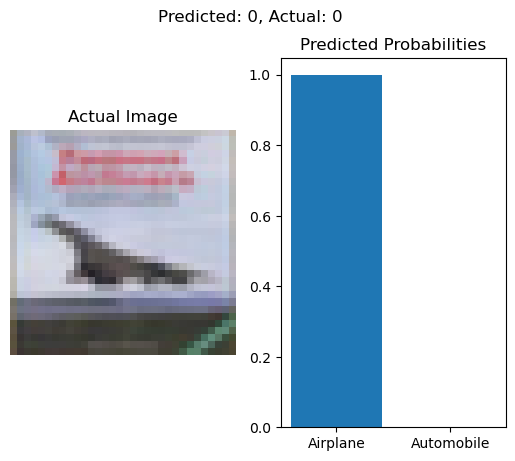

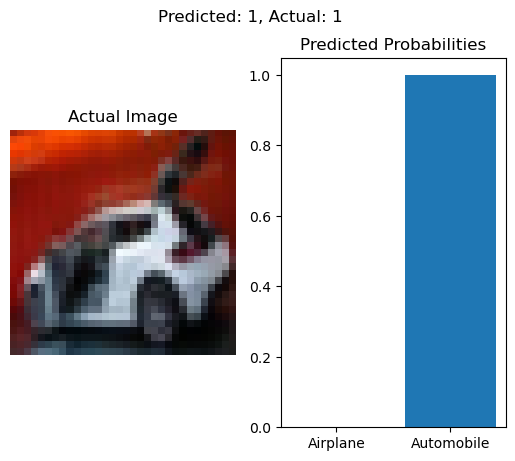

In [35]:
# Calculate accuracy on test set
speaker.eval()
listener.eval()
correct = 0
total = 0
with torch.no_grad():
    for image, label in testset:
        message = speaker(image.unsqueeze(0))
        output = listener(message)
        predicted_label = output.argmax(dim=1).item()
        if predicted_label == label:
            correct += 1
        total += 1

accuracy = correct / total * 100
print(f"Accuracy on test set: {accuracy:.2f}%")

# Show predicted labels and actual labels for two images from the test set
with torch.no_grad():
    for i in range(2):
        image, label = testset[i]
        message = speaker(image.unsqueeze(0))
        output = listener(message)
        predicted_label = output.argmax(dim=1).item()

        # Convert image tensor to numpy array and transpose dimensions
        image_np = image.permute(1, 2, 0).numpy()

        # Denormalize image array
        image_np = (image_np * 0.5) + 0.5

        # Show predicted and actual labels and images using matplotlib
        fig, ax = plt.subplots(nrows=1, ncols=2)
        fig.suptitle(f"Predicted: {predicted_label}, Actual: {label}")
        ax[0].imshow(image_np)
        ax[0].set_title("Actual Image")
        ax[0].axis("off")
        ax[1].bar(range(2), output.squeeze().numpy())
        ax[1].set_xticks(range(2))
        ax[1].set_xticklabels(["Airplane", "Automobile"])
        ax[1].set_title("Predicted Probabilities")
        plt.show()
